## **0. Environment Setups**

In [154]:
# Path to your working directory
ROOT = "/content/drive/MyDrive/DAM202-Practicals"
import os
os.chdir(ROOT)

# Install required packages
!pip install gensim nltk numpy scipy scikit-learn

In [155]:
#import os
os.listdir()

['Word2Vec.ipynb',
 'alice.txt',
 '.ipynb_checkpoints',
 'word2vec_model(CBOW).model',
 'word2vec_model(SG).model',
 'Practical2(Word2Vec).ipynb']

## **1. Code Implementation**

### **1.1 Data Collection and Preparation**

In [156]:
# Load your text data
with open('alice.txt', 'r', encoding='utf-8') as f:
    texts = f.readlines()

# Check initial data
print(f"Loaded {len(texts)} text documents")
print("Sample texts:", texts[:3])

Loaded 3599 text documents
Sample texts: ["                ALICE'S ADVENTURES IN WONDERLAND\n", '\n', '                          Lewis Carroll\n']


### **1.2 Data Quality Assessment**

In [157]:
def assess_data_quality(texts):
    """Analyze text data quality for Word2Vec training"""

    stats = {
        'total_documents': len(texts),
        'total_words': 0,
        'unique_words': set(),
        'sentence_lengths': [],
        'word_frequencies': {}
    }

    for text in texts:
        words = text.lower().split()
        stats['total_words'] += len(words)
        stats['sentence_lengths'].append(len(words))
        stats['unique_words'].update(words)

        for word in words:
            stats['word_frequencies'][word] = stats['word_frequencies'].get(word, 0) + 1

    stats['vocabulary_size'] = len(stats['unique_words'])
    stats['avg_sentence_length'] = sum(stats['sentence_lengths']) / len(stats['sentence_lengths'])

    # Find most common words
    sorted_words = sorted(stats['word_frequencies'].items(), key=lambda x: x[1], reverse=True)
    stats['top_words'] = sorted_words[:20]

    # Quality indicators
    stats['quality_score'] = {
        'vocabulary_diversity': stats['vocabulary_size'] / stats['total_words'],
        'avg_word_frequency': stats['total_words'] / stats['vocabulary_size'],
        'rare_words_ratio': sum(1 for count in stats['word_frequencies'].values() if count == 1) / stats['vocabulary_size']
    }

    return stats

# Example usage
quality_report = assess_data_quality(texts)
print(f"Total documents: {quality_report['total_documents']:,}")
print(f"Vocabulary size: {quality_report['vocabulary_size']:,}")
print(f"Unique Words: {quality_report['unique_words']}")
print(f"Average sentence length: {quality_report['avg_sentence_length']:.1f}")
print(f"Vocabulary diversity: {quality_report['quality_score']['vocabulary_diversity']:.4f}")

Total documents: 3,599
Vocabulary size: 4,950
Unique Words: {'tunnel', 'tried', 'suppose', 'i?', 'scroll,', 'truthful', "sing?'", 'teaching', 'began:--', "can't", 'suddenly:', 'confused,', 'morning', 'doubt', 'delighted', 'cheeks,', 'out', 'chorus,', 'suddenly,', 'flashed', 'blew', '`no,', 'generally,', 'unfortunate', 'night?', 'nibbled', "dinner!'", "raw.'", 'tail.', 'trotting', 'ear.', 'knocking,', 'tea.', 'obstacle', 'sob,', 'five!', 'invented', 'present--', 'fulcrum', 'way.', 'brown,', 'while,', "usual,'", 'canterbury,', 'replied', 'spoke,', 'folded', 'five.', '`digging', 'proceed.', 'sadly', 'meekly', "here.'", '"he\'s', 'lewis', 'able!', 'begin', 'way!', 'frowning,', 'beating.', 'position', 'side.', 'croqueted', 'next!', 'hare:', 'applause,', 'asking,', "thing,'", 'ever;', 'tones', 'duck.', 'belt', 'hot', 'surprised', 'piece', 'sigh,', "dormouse,'", 'holding', 'mistake', 'dispute', 'leaves:', "dream!'", 'half-past', 'hare,)', 'old,', 'began,', 'beast,', "whiting,'", 'wait,', 'nos

### **1.3 Text Processing Pipeline**

In [158]:
#Import Packages
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import nltk

In [159]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [160]:
class AdvancedTextPreprocessor:
    """Comprehensive text preprocessing for Word2Vec training"""

    def __init__(self,
                 lowercase=True,
                 remove_punctuation=True,
                 remove_numbers=False,
                 remove_stopwords=False,
                 min_word_length=2,
                 max_word_length=50,
                 lemmatize=False,
                 remove_urls=True,
                 remove_emails=True,
                 keep_sentences=True):

        self.lowercase = lowercase
        self.remove_punctuation = remove_punctuation
        self.remove_numbers = remove_numbers
        self.remove_stopwords = remove_stopwords
        self.min_word_length = min_word_length
        self.max_word_length = max_word_length
        self.lemmatize = lemmatize
        self.remove_urls = remove_urls
        self.remove_emails = remove_emails
        self.keep_sentences = keep_sentences

        if remove_stopwords:
            self.stop_words = set(stopwords.words('english'))

        if lemmatize:
            self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """Clean individual text string"""

        # Remove URLs
        if self.remove_urls:
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove email addresses
        if self.remove_emails:
            text = re.sub(r'\S+@\S+', '', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        #Combined
         #(r'https?://\S+|www\.\S+|<.*?>|\S+@\S+\.\S+|@\w+|#\w+|[^A-Za-z0-9\s])

        return text

    def tokenize_text(self, text):
        """Tokenize text into sentences or words"""

        if self.keep_sentences:
            # Tokenize into sentences first
            sentences = sent_tokenize(text)
            processed_sentences = []

            for sentence in sentences:
                words = self.process_sentence(sentence)
                if len(words) >= 3:  # Keep sentences with at least 3 words
                    processed_sentences.append(words)

            return processed_sentences
        else:
            # Return single list of words
            return self.process_sentence(text)

    def process_sentence(self, sentence):
        """Process individual sentence"""

        # Lowercase
        if self.lowercase:
            sentence = sentence.lower()

        # Tokenize into words
        words = word_tokenize(sentence)

        processed_words = []
        for word in words:

            # Remove punctuation
            if self.remove_punctuation:
                word = word.translate(str.maketrans('', '', string.punctuation))

            # Skip if empty after punctuation removal
            if not word:
                continue

            # Remove numbers
            if self.remove_numbers and word.isdigit():
                continue

            # Check word length
            if len(word) < self.min_word_length or len(word) > self.max_word_length:
                continue

            # Remove stopwords
            if self.remove_stopwords and word in self.stop_words:
                continue

            # Lemmatize
            if self.lemmatize:
                word = self.lemmatizer.lemmatize(word)

            processed_words.append(word)

        return processed_words

    def preprocess_corpus(self, texts):
        """Preprocess entire corpus"""

        all_sentences = []

        for text in texts:
            if not isinstance(text, str):
                continue

            # Clean text
            cleaned_text = self.clean_text(text)

            # Tokenize and process
            processed = self.tokenize_text(cleaned_text)

            if self.keep_sentences:
                all_sentences.extend(processed)
            else:
                all_sentences.append(processed)

        return all_sentences

In [161]:
# Example usage
preprocessor = AdvancedTextPreprocessor(
    lowercase=True,
    remove_punctuation = True,
    remove_numbers=True,
    remove_stopwords=False,  # Keep stopwords for Word2Vec
    lemmatize=False,  # Usually not needed for Word2Vec
    keep_sentences=True
)

# Processing corpus
processed_sentences = preprocessor.preprocess_corpus(texts)
print(f"Processed {len(processed_sentences)} sentences")
print(f"Sample sentence: {processed_sentences[0]}")

Processed 2941 sentences
Sample sentence: ['alice', 'adventures', 'in', 'wonderland']


In [162]:
processed_sentences[:10]

[['alice', 'adventures', 'in', 'wonderland'],
 ['the', 'millennium', 'fulcrum', 'edition'],
 ['down', 'the', 'rabbithole'],
 ['alice',
  'was',
  'beginning',
  'to',
  'get',
  'very',
  'tired',
  'of',
  'sitting',
  'by',
  'her',
  'sister'],
 ['on',
  'the',
  'bank',
  'and',
  'of',
  'having',
  'nothing',
  'to',
  'do',
  'once',
  'or',
  'twice',
  'she',
  'had'],
 ['peeped',
  'into',
  'the',
  'book',
  'her',
  'sister',
  'was',
  'reading',
  'but',
  'it',
  'had',
  'no'],
 ['pictures',
  'or',
  'conversations',
  'in',
  'it',
  'and',
  'what',
  'is',
  'the',
  'use',
  'of',
  'book'],
 ['thought', 'alice', 'without', 'pictures', 'or', 'conversation'],
 ['so',
  'she',
  'was',
  'considering',
  'in',
  'her',
  'own',
  'mind',
  'as',
  'well',
  'as',
  'she',
  'could'],
 ['for',
  'the',
  'hot',
  'day',
  'made',
  'her',
  'feel',
  'very',
  'sleepy',
  'and',
  'stupid',
  'whether']]

### **1.4 Training Parameters**

In [163]:
def recommend_parameters(corpus_size, vocab_size, domain_type, computing_resources):
    """
    Recommend Word2Vec parameters based on corpus characteristics

    Args:
        corpus_size: Number of sentences/documents
        vocab_size: Unique words in vocabulary
        domain_type: 'general', 'technical', 'social_media', 'academic'
        computing_resources: 'limited', 'moderate', 'high'
    """

    recommendations = {}

    # Vector size based on corpus and vocab size
    if corpus_size < 10000:
        recommendations['vector_size'] = 50
    elif corpus_size < 100000:
        recommendations['vector_size'] = 100
    elif corpus_size < 1000000:
        recommendations['vector_size'] = 200
    else:
        recommendations['vector_size'] = 300

    # Window size based on domain
    domain_windows = {
        'general': 5,
        'technical': 3,  # More syntactic focus
        'social_media': 4,
        'academic': 6    # More semantic focus
    }
    recommendations['window'] = domain_windows.get(domain_type, 5)

    # Min count based on corpus size
    if corpus_size < 10000:
        recommendations['min_count'] = 1
    elif corpus_size < 100000:
        recommendations['min_count'] = 2
    elif corpus_size < 1000000:
        recommendations['min_count'] = 5
    else:
        recommendations['min_count'] = 10

    # Algorithm selection
    if domain_type in ['technical', 'academic']:
        recommendations['sg'] = 1  # Skip-gram for rare technical terms
    else:
        recommendations['sg'] = 0  # CBOW for general text

    # Epochs based on corpus size and resources
    if computing_resources == 'limited':
        recommendations['epochs'] = 5
    elif corpus_size < 100000:
        recommendations['epochs'] = 15
    else:
        recommendations['epochs'] = 10

    # Hierarchical softmax vs negative sampling
    if vocab_size > 100000:
        recommendations['hs'] = 1
        recommendations['negative'] = 0
    else:
        recommendations['hs'] = 0
        recommendations['negative'] = 10

    return recommendations

### **1.5 Step-by-Step Implementation**

In [164]:
pip install gensim

In [165]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import time
import multiprocessing

class EpochLogger(CallbackAny2Vec):
    """Callback to log information about training progress"""

    def __init__(self):
        self.epoch = 0
        self.start_time = time.time()

    def on_epoch_begin(self, model):
        print(f"Epoch #{self.epoch} start")

    def on_epoch_end(self, model):
        elapsed = time.time() - self.start_time
        print(f"Epoch #{self.epoch} end - Time elapsed: {elapsed:.2f}s")
        self.epoch += 1

def train_word2vec_model(sentences, save_path=None, **params):
    """
    Train Word2Vec model with given parameters

    Args:
        sentences: List of tokenized sentences
        save_path: Path to save the model
        **params: Word2Vec parameters
    """

    # Set default parameters
    default_params = {
        'vector_size': 100,          # Good for small-mid corpus
        'window': 8,                 # Larger window for narrative context
        'min_count': 2,              # Lower to capture more rare words
        'workers': multiprocessing.cpu_count(),
        'sg': 0,                     # CBOW good for smaller datasets
        'epochs': 30,                # More epochs for better learning
        'alpha': 0.025,              # Initial learning rate
        'min_alpha': 0.0001,         # Final learning rate
        'hs': 0,                     # Use negative sampling
        'negative': 10,              # More negative samples
        'compute_loss': True,        # Track training loss
    }

    # Update with provided parameters
    default_params.update(params)

    print("Training Word2Vec model with parameters:")
    for key, value in default_params.items():
        print(f"  {key}: {value}")

    # Add callback for progress monitoring
    epoch_logger = EpochLogger()

    # Train the model
    print(f"\nTraining on {len(sentences)} sentences...")
    start_time = time.time()

    model = Word2Vec(
        sentences=sentences,
        callbacks=[epoch_logger],
        **default_params
    )

    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")
    print(f"Vocabulary size: {len(model.wv)} words")

    # Save model if path provided
    if save_path:
        model.save(save_path)
        print(f"Model saved to {save_path}")

    return model

In [166]:
from tkinter.constants import S
# Example usage
model = train_word2vec_model(
    sentences=processed_sentences,
    save_path='word2vec_model(SG).model',
    vector_size=100,
    window=3,
    min_count=2,
    sg=1,          # CBOW
    negative=10,
    epochs=50,
)

Training Word2Vec model with parameters:
  vector_size: 100
  window: 3
  min_count: 2
  workers: 2
  sg: 1
  epochs: 50
  alpha: 0.025
  min_alpha: 0.0001
  hs: 0
  negative: 10
  compute_loss: True

Training on 2941 sentences...
Epoch #0 start
Epoch #0 end - Time elapsed: 0.31s
Epoch #1 start
Epoch #1 end - Time elapsed: 0.49s
Epoch #2 start
Epoch #2 end - Time elapsed: 0.63s
Epoch #3 start
Epoch #3 end - Time elapsed: 0.72s
Epoch #4 start
Epoch #4 end - Time elapsed: 0.80s
Epoch #5 start
Epoch #5 end - Time elapsed: 0.88s
Epoch #6 start
Epoch #6 end - Time elapsed: 0.96s
Epoch #7 start
Epoch #7 end - Time elapsed: 1.04s
Epoch #8 start
Epoch #8 end - Time elapsed: 1.14s
Epoch #9 start
Epoch #9 end - Time elapsed: 1.22s
Epoch #10 start
Epoch #10 end - Time elapsed: 1.30s
Epoch #11 start
Epoch #11 end - Time elapsed: 1.38s
Epoch #12 start
Epoch #12 end - Time elapsed: 1.46s
Epoch #13 start
Epoch #13 end - Time elapsed: 1.54s
Epoch #14 start
Epoch #14 end - Time elapsed: 1.63s
Epoch #15

In [167]:
vocab_size = len(model.wv.index_to_key)
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 1396


In [168]:
all_words = model.wv.index_to_key
print("All Words in Vocabulary:", all_words[:10])

All Words in Vocabulary: ['the', 'and', 'to', 'it', 'she', 'of', 'said', 'you', 'in', 'was']


### **1.6 Model Evaluation and Validation**

In [169]:
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity

class Word2VecEvaluator:
    """Comprehensive evaluation suite for Word2Vec models"""

    def __init__(self, model):
        self.model = model
        self.wv = model.wv

    def evaluate_word_similarity(self, word_pairs_with_scores):
        """
        Evaluate model on word similarity datasets

        Args:
            word_pairs_with_scores: List of tuples (word1, word2, human_score)

        Returns:
            Spearman correlation with human judgments
        """

        model_similarities = []
        human_similarities = []

        for word1, word2, human_score in word_pairs_with_scores:
            try:
                model_sim = self.wv.similarity(word1, word2)
                model_similarities.append(model_sim)
                human_similarities.append(human_score)
            except KeyError:
                # Skip if words not in vocabulary
                continue

        if len(model_similarities) < 10:
            print("Warning: Too few valid word pairs for reliable evaluation")
            return None

        correlation, p_value = spearmanr(human_similarities, model_similarities)

        print(f"Word Similarity Evaluation:")
        print(f"Valid pairs: {len(model_similarities)}")
        print(f"Spearman correlation: {correlation:.4f}")
        print(f"P-value: {p_value:.4f}")

        return correlation

    def evaluate_analogies(self, analogy_dataset):
        """
        Evaluate model on word analogy tasks

        Args:
            analogy_dataset: List of tuples (word_a, word_b, word_c, word_d)
                           representing "word_a is to word_b as word_c is to word_d"

        Returns:
            Accuracy on analogy task
        """

        correct = 0
        total = 0
        #('king', 'queen', 'man', 'woman'),
        for word_a, word_b, word_c, expected_d in analogy_dataset:
            try:
                # Predict word_d
                result = self.wv.most_similar(
                    positive=[word_a, word_b],
                    negative=[word_c],
                    topn=1
                )

                predicted_d = result

                if predicted_d[0][0].lower() == expected_d.lower():
                    correct += 1

                total += 1

            except (KeyError, IndexError):
                # Skip if words not in vocabulary
                continue

        if total == 0:
            print("Warning: No valid analogies found")
            return 0

        accuracy = correct / total

        print(f"Analogy Evaluation:")
        print(f"Valid analogies: {total}")
        print(f"Correct predictions: {correct}")
        print(f"Accuracy: {accuracy:.4f}")

        return accuracy

    def evaluate_odd_one_out(self, word_groups):
        """
        Evaluate model's ability to identify odd words in groups

        Args:
            word_groups: List of lists, each containing words where one doesn't belong

        Returns:
            Accuracy on odd-one-out task
        """

        correct = 0
        total = 0

        for group in word_groups:
            if len(group) < 3:
                continue

            try:
                # Find the word that doesn't match others
                odd_word = self.wv.doesnt_match(group)

                # This is tricky - we need ground truth to evaluate properly
                # For now, just check if the model can identify AN odd word
                correct += 1  # Placeholder - you'd need labeled data
                total += 1

            except KeyError:
                continue

        if total == 0:
            return 0

        accuracy = correct / total

        print(f"Odd-One-Out Evaluation:")
        print(f"  Valid groups: {total}")
        print(f"  Accuracy: {accuracy:.4f}")

        return accuracy

    def analyze_vocabulary_coverage(self, test_texts):
        """
        Analyze how well model vocabulary covers test texts

        Args:
            test_texts: List of text strings

        Returns:
            Coverage statistics
        """

        vocab = set(self.wv.index_to_key)

        total_words = 0
        covered_words = 0
        unknown_words = set()

        for text in test_texts:
            words = text.lower().split()
            total_words += len(words)

            for word in words:
                if word in vocab:
                    covered_words += 1
                else:
                    unknown_words.add(word)

        coverage_ratio = covered_words / total_words if total_words > 0 else 0

        print(f"Vocabulary Coverage Analysis:")
        print(f"  Total words in test: {total_words}")
        print(f"  Covered words: {covered_words}")
        print(f"  Coverage ratio: {coverage_ratio:.4f}")
        print(f"  Unknown words: {len(unknown_words)}")

        return {
            'coverage_ratio': coverage_ratio,
            'unknown_words': list(unknown_words)[:20],  # Show first 20
            'total_unknown': len(unknown_words)
        }

    def compare_with_baseline(self, baseline_model, test_words):
        """
        Compare model performance with baseline model

        Args:
            baseline_model: Another Word2Vec model to compare against
            test_words: List of words to test

        Returns:
            Comparison statistics
        """

        common_words = []
        for word in test_words:
            if word in self.wv and word in baseline_model.wv:
                common_words.append(word)

        if len(common_words) < 10:
            print("Warning: Too few common words for reliable comparison")
            return None

        # Compare similarity patterns
        similarities = []

        for i, word1 in enumerate(common_words[:20]):  # Test subset
            for word2 in common_words[i+1:21]:  # Avoid too many comparisons

                sim1 = self.wv.similarity(word1, word2)
                sim2 = baseline_model.wv.similarity(word1, word2)

                similarities.append((sim1, sim2))

        model_sims = [s for s in similarities]
        baseline_sims = [s for s in similarities]

        correlation, _ = spearmanr(model_sims, baseline_sims)

        print(f"Model Comparison:")
        print(f"  Common vocabulary: {len(common_words)}")
        print(f"  Similarity correlation: {correlation:.4f}")

        return correlation

In [170]:
character_analogies = [
    # Character roles and relationships
    ('alice', 'adventurer', 'rabbit', 'guide'),
    ('queen', 'ruler', 'king', 'ruler'),
    ('hatter', 'mad', 'march', 'hare'),
    ('dormouse', 'sleepy', 'cat', 'grinning'),

    # Character size relationships (Alice changes size frequently)
    ('alice', 'small', 'rabbit', 'large'),
    ('alice', 'grow', 'drink', 'shrink'),

    # Character-to-object relationships
    ('rabbit', 'pocket_watch', 'hatter', 'teacup'),
    ('queen', 'crown', 'king', 'crown'),
]

character_similarity_pairs = [
    ('alice', 'curious', 8.5),
    ('queen', 'tyrannical', 8.0),
    ('rabbit', 'hurried', 8.2),
    ('hatter', 'eccentric', 8.5),
    ('cat', 'mysterious', 8.3),
    ('dormouse', 'sleepy', 8.7),
]

# Fixed variable names
evaluator = Word2VecEvaluator(model)
sim_score = evaluator.evaluate_word_similarity(character_similarity_pairs)
analogy_score = evaluator.evaluate_analogies(character_analogies)

Analogy Evaluation:
Valid analogies: 5
Correct predictions: 0
Accuracy: 0.0000


In [171]:
word = "alice"
if word in model.wv:
    similar_words = model.wv.most_similar(word, topn=10)
    print(f"Most similar words to '{word}':")
    for similar_word, similarity in similar_words:
        print(f"{similar_word}: {similarity}")
else:
    print("Word is not in the vocabulary.")

Most similar words to 'alice':
she: 0.6020103693008423
cautiously: 0.5731974840164185
thoughtfully: 0.5728407502174377
decidedly: 0.5672253370285034
animal: 0.5665189027786255
sharply: 0.5647569894790649
english: 0.5631624460220337
pig: 0.5558809638023376
grave: 0.5460782051086426
loudly: 0.5452850461006165


In [172]:
model.wv.similarity('alice', 'timidly')

0.46429735

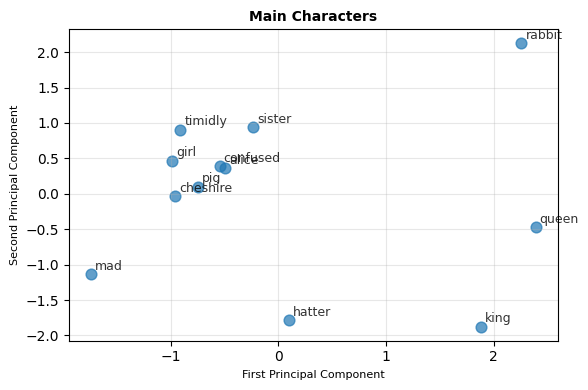

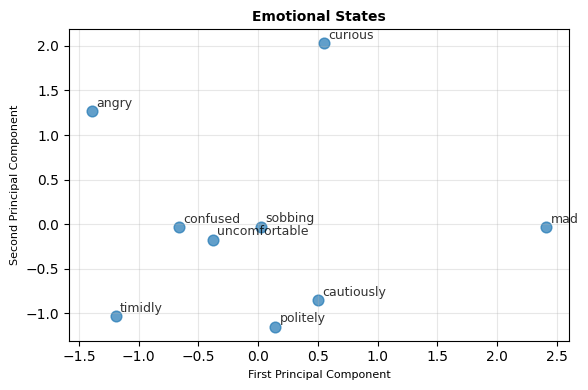

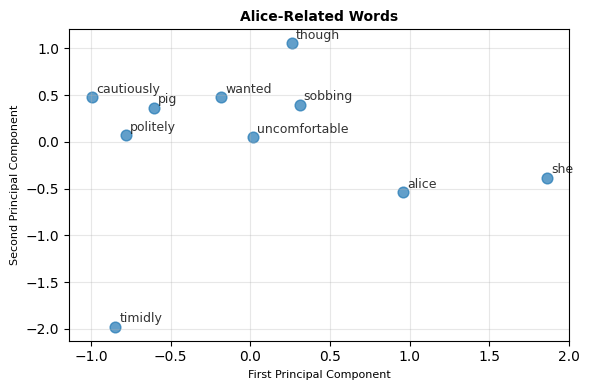

In [173]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_embeddings(model, words, title="Word Embeddings"):
    # Get vectors only for words that exist in vocabulary
    vectors = []
    valid_words = []
    for word in words:
        if word in model.wv:
            vectors.append(model.wv[word])
            valid_words.append(word)

    if len(vectors) < 2:
        print(f"Not enough valid words for visualization. Only found: {valid_words}")
        return

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    result = pca.fit_transform(vectors)

    # Create smaller plot
    plt.figure(figsize=(6, 4))  # Smaller figure size
    plt.scatter(result[:, 0], result[:, 1], s=60, alpha=0.7)

    # Add labels with smaller font
    for i, word in enumerate(valid_words):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]),
                    xytext=(3, 3), textcoords='offset points',
                    fontsize=9, alpha=0.8)

    plt.title(f'{title}', fontsize=10, fontweight='bold')
    plt.xlabel('First Principal Component', fontsize=8)
    plt.ylabel('Second Principal Component', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot main characters (smaller version)
main_characters = ['alice', 'rabbit', 'queen', 'king', 'cheshire', 'mad', 'hatter', 'timidly', 'pig', 'sister', 'girl', 'confused']
plot_embeddings(model, main_characters, "Main Characters")

# Plot emotional states and behaviors
emotional_words = ['timidly', 'politely', 'cautiously', 'sobbing', 'uncomfortable', 'confused', 'curious', 'brave', 'angry', 'mad']
plot_embeddings(model, emotional_words, "Emotional States")

# Plot relationships
related_words = ['alice', 'pig', 'timidly', 'uncomfortable', 'sobbing', 'politely', 'she', 'cautiously', 'though', 'wanted']
plot_embeddings(model, related_words, "Alice-Related Words")

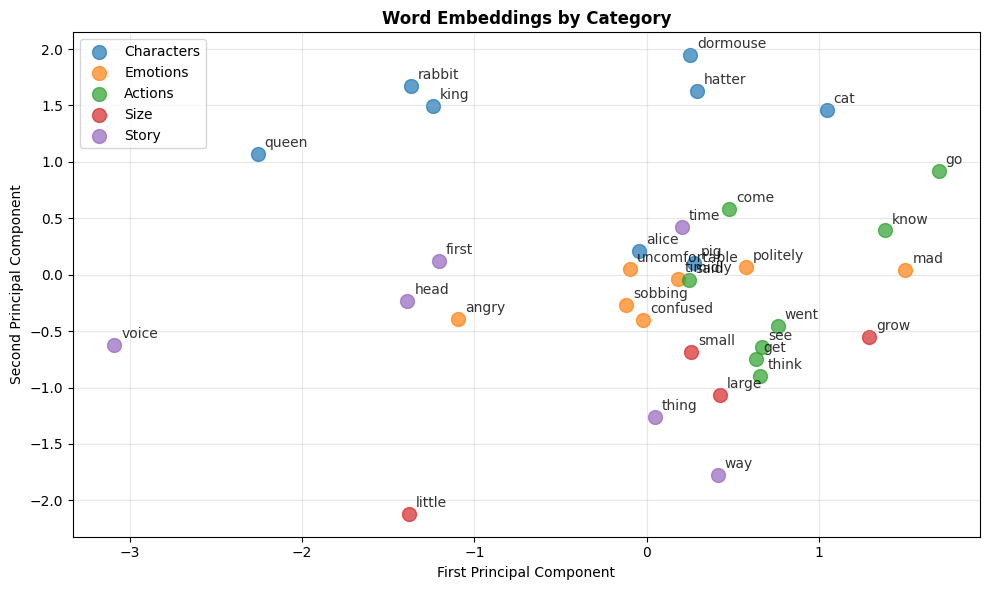

In [174]:
# Enhanced visualization with different categories
def plot_embeddings_by_category(model, word_categories):
    all_words = []
    all_vectors = []
    labels = []
    colors = []

    color_map = plt.cm.tab10  # Using a color map for different categories

    for i, (category, words) in enumerate(word_categories.items()):
        for word in words:
            if word in model.wv:
                all_words.append(word)
                all_vectors.append(model.wv[word])
                labels.append(category)
                colors.append(color_map(i % 10))  # Cycle through colors

    if len(all_vectors) < 2:
        print("Not enough words for visualization")
        return

    # Apply PCA
    pca = PCA(n_components=2)
    result = pca.fit_transform(all_vectors)

    # Create plot
    plt.figure(figsize=(10, 6))

    # Plot each category with different colors
    for i, category in enumerate(word_categories.keys()):
        indices = [j for j, label in enumerate(labels) if label == category]
        if indices:
            plt.scatter(result[indices, 0], result[indices, 1],
                       color=color_map(i % 10), s=100, alpha=0.7, label=category)

    # Add labels
    for i, word in enumerate(all_words):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=10, alpha=0.8)

    plt.title('Word Embeddings by Category', fontsize=12, fontweight='bold')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Define categories based on your model's vocabulary
word_categories = {
    'Characters': ['alice', 'rabbit', 'queen', 'king', 'hatter', 'dormouse', 'cat', 'pig'],
    'Emotions': ['timidly', 'politely', 'uncomfortable', 'sobbing', 'confused', 'mad', 'angry'],
    'Actions': ['said', 'went', 'think', 'know', 'see', 'go', 'come', 'get'],
    'Size': ['small', 'large', 'little', 'big', 'grow', 'shrink'],
    'Story': ['time', 'way', 'voice', 'head', 'thing', 'first']
}

plot_embeddings_by_category(model, word_categories)

#### 1.6.1 Cluster Visualizations

In [175]:
# Check cosine similarities between key words
print("=== COSINE SIMILARITIES ===")
key_pairs = [
    ('alice', 'pig'),
    ('alice', 'timidly'),
    ('alice', 'uncomfortable'),
    ('queen', 'king'),
    ('rabbit', 'mouse'),
    ('hatter', 'mad'),
]

for word1, word2 in key_pairs:
    if word1 in model.wv and word2 in model.wv:
        similarity = model.wv.similarity(word1, word2)
        print(f"{word1} - {word2}: {similarity:.3f}")
    else:
        missing = [word for word in [word1, word2] if word not in model.wv]
        print(f"Cannot compare {word1}-{word2}: {missing} missing")

=== COSINE SIMILARITIES ===
alice - pig: 0.556
alice - timidly: 0.464
alice - uncomfortable: 0.541
queen - king: 0.401
rabbit - mouse: 0.270
hatter - mad: 0.288
